In [1]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values
    

In [2]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [6]:
# Attempting Mini-Batch K means with some different number of centroids, and computing their scores.
num_centroids = xrange(2, 20)
kmeans = [MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000) for i in num_centroids]

start_time = datetime.now()
scores = [kmeans[j].fit(data).score(data) for j in range(len(kmeans))]
print('Elapsed time: {}'.format(datetime.now() - start_time))

Elapsed time: 0:01:03.790887


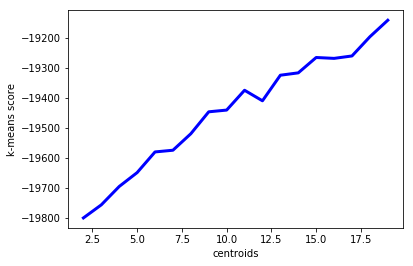

In [7]:
# Plot an elbow curve.
plt.plot(num_centroids, scores, color='blue', linewidth=3)
plt.xlabel('centroids')
plt.ylabel('k-means score')
plt.show()